In [8]:
import numpy as np
import mdtraj as md
import cv2 as cv
import matplotlib.pyplot as plt
import os

## Converting `.npz` back to `.lammpstrj`

In [2]:
def npz2lammpstrj(fname, outPath):
    if outPath[-10:] != '.lammpstrj':
        outPath += '.lammpstrj'
    if fname[-4:] != '.npz':
        fname += '.npz'
    data = np.load(fname)
    out = md.formats.LAMMPSTrajectoryFile(outPath, 
                                      mode = 'w', 
                                      force_overwrite=True).write(data['xyz'], 
                                                                  data['cell_lengths'], 
                                                                  data['cell_angles'], 
                                                                  types = data['types'].tolist())
    return

In [3]:
npz2lammpstrj('hand_24.npz', 'output_test')

## Compute the area of a pore using `.pdb` file

In [9]:
def areaFromPdb(pdbPath):
    if pdbPath[-4:] != '.pdb':
        pdbPath += '.pdb'
    fp = open(pdbPath, "r")
    contents = fp.readlines()[1:-1]
    info = []
    coords = np.array([list(map(float,x.split()[6:8])) for x in contents])
    fp.close()
    #https://stackoverflow.com/questions/33094509/correct-sizing-of-markers-in-scatter-plot-to-a-radius-r-in-matplotlib
    figure = plt.figure(figsize=[5, 5])
    ax = plt.axes([0, 0, 1, 1], xlim=(0, 40), ylim=(0, 40))
    points_whole_ax = 5 *1 * 72    # 1 point = dpi / 72 pixels
    radius = 3.39/2
    points_radius = 2 * radius / (40) * points_whole_ax
    ax.scatter(coords[:,0], coords[:, 1], s=points_radius**2, color='grey', edgecolors = 'k')
    ax.axis('off')
    plt.savefig('temp.png')
    plt.close()
    ################Area from Image#############
    img = cv.imread('temp.png')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    ret,thresh = cv.threshold(gray,127,255,0)
    contours,hierarchy = cv.findContours(thresh, 
                                         cv.RETR_TREE, 
                                         cv.CHAIN_APPROX_NONE)
    print('Number of contours = ', str(len(contours)))
    ##############Get areas for all contours###########
    areas = [cv.contourArea(c) for c in contours]
    ###########Get the largest contour##########
    sort_index = np.argsort(areas)[::-1]
    ind = sort_index[0]
    ###########Scale conversion##################
    rate = (40**2)/(360**2)
    ###########################################
    final_area = areas[ind] * rate
    print('Area:', areas[ind] * rate)
    os.remove('temp.png')
    return final_area

In [10]:
areaFromPdb('circle_33')

Number of contours =  631
Area: 53.48148148148148


53.48148148148148

## Get coordinates of a specific kind of atoms

In [12]:
type_dict = {
    'piston': 1,
    'membrane': 2,
    'oxygen': 3,
    'hydrogen': 4,
    'potassium': 5,
    'chloride': 6
}

In [25]:
"""
Arg: fname is the type of .npz file to be read
     atomType is a string of atom type name
"""
def coordByType(fname, atomType):
    try:
        typeCode = type_dict[atomType]
    except KeyError:
        print('Unknown atom type!')
        return
    
    data = np.load(fname, allow_pickle=True)
    coords = data['xyz']
    idx = np.where(data['types'] == typeCode)[0]
    return coords[:, idx]

In [37]:
oxygen = coordByType('hand_24.npz','oxygen')
piston = coordByType('hand_24.npz','piston')
membrane = coordByType('hand_24.npz','membrane')
potassium = coordByType('hand_24.npz','potassium')
chloride = coordByType('hand_24.npz','chloride')

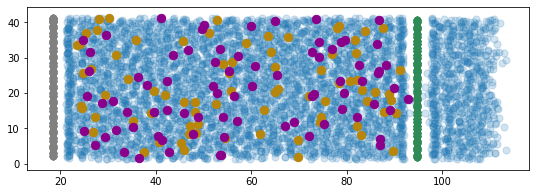

In [66]:
plt.figure(figsize = [9, 3])
plt.scatter(oxygen[50][:, 2], oxygen[50][:, 1], s = 50, alpha = 0.2)
plt.scatter(piston[50][:, 2], piston[50][:, 1], s = 40, c = 'grey')
plt.scatter(membrane[50][:, 2], membrane[50][:, 1], s = 40, c = 'seagreen')
plt.scatter(potassium[50][:, 2], potassium[50][:, 1], s = 70, c = 'darkgoldenrod')
plt.scatter(chloride[50][:, 2], chloride[50][:, 1], s = 70, c = 'darkmagenta')
plt.show()

## Calculate the water flux from each trajectory

### 1. Plot the No. of water filetered vs time curve

In [71]:
def filteredWater(fname):
    ######Index of needed atoms (oxygens, piston, membrane)
    atom_id = list(range(680,14472,3)) #681 to 14473 spaced by 3 is the index of oxygen atoms
    atom_id.append(1) #14631 will always be the number of first membrane atom index
    atom_id.append(-1)
    #######################
    if fname[-4:] != '.npz':
        fname += '.npz'
    data = np.load(fname)
    xyz = data['xyz'][:, atom_id, :]
    molecule_filtered = []
    print('Calculating water filtered at each time frame')
    for frame in xyz:
        piston = frame[-2,2]
        memb = frame[-1,2]
        filtered_water = len([1 for i in frame[:,2] if i>piston and i<memb])
        molecule_filtered.append(filtered_water)
    starting = molecule_filtered[0]
    molecule_filtered[:] = [ (-x+starting) for x in molecule_filtered]
    print('Finished')
    data.close()
    return molecule_filtered

In [69]:
filtered = filteredWater('hand_24')

Calculating water filtered
Finished


In [77]:
def plot_flux(w_filtered):
    timesteps = list(range(len(w_filtered)))
    timesteps[:] = [ts/200 for ts in timesteps]
    plot, = plt.plot(timesteps,w_filtered, linewidth = 0.8)
    plt.xlabel('Time (ns)')
    plt.ylabel('# of filtered water molecules')
    plt.show()
    return

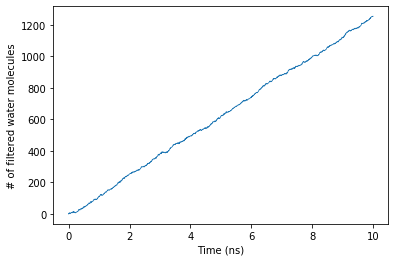

In [78]:
plot_flux(filtered)

### Calculate water flux by fitting a the slope of the curve

In [92]:
def getFlux(w_filtered):
    timesteps = list(range(len(w_filtered)))
    timesteps[:] = [ts/200 for ts in timesteps]
    print('Running time: ', timesteps[-1])
    t = np.vstack([timesteps, np.ones(len(timesteps))]).T
    m,k = np.linalg.lstsq(t,w_filtered,rcond = None)[0]
    print('Flux: '+"{:.2f}".format(round(m, 2))+' #/ns')
    return m

In [93]:
getFlux(filtered)

Running time:  10.0
Flux: 126.12 #/ns


126.12003558660233

## Decompress a selected trajectory

### Need to write a function to decompress a chosen trajectory. e.g. if user want `hand_24.npz`, this function takes `hand_24.npz` or `hand_24` as input, and extract the file from the compressed folder. 